In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt install htop
!pip install transformers==4.8.2 datasets
!git clone https://github.com/agiantwhale/jaegpt.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  strace
The following NEW packages will be installed:
  htop
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 80.0 kB of archives.
After this operation, 221 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 htop amd64 2.1.0-3 [80.0 kB]
Fetched 80.0 kB in 1s (145 kB/s)
Selecting previously unselected package htop.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../htop_2.1.0-3_amd64.deb ...
Unpacking htop (2.1.0-3) ...
Setting up htop (2.1.0-3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
     |████████████████████████████████| 2.5MB 5.2MB/s 
     |████████████████████████████████| 266kB 35.5MB/s 
     |████████████████████████████████| 3.3MB 34.2MB/s 
     |███████████████████████████

In [3]:
import transformers
from os import cpu_count
from datasets import load_dataset
from jaegpt.fbgpt.data_utils import tokenize_function

In [4]:
datasets = load_dataset(
    'json', data_files=['/content/drive/MyDrive/ColabData/input_data/fb_shuf.json']
)['train']

tokenizer = transformers.GPT2Tokenizer.from_pretrained(
    'microsoft/DialoGPT-small'
)

Using custom data configuration default-d37974732790773b


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-d37974732790773b/0.0.0/793d004298099bd3c4e61eb7878475bcf1dc212bf2e34437d85126758720d7f9. Subsequent calls will reuse this data.


In [5]:
def get_yield(block_size: int):
    num_process = cpu_count() - 1

    lm_datasets = datasets.map(
        lambda x: tokenize_function(x, tokenizer, block_size),
        batched=True,
        num_proc=num_process
    )
    lm_datasets = lm_datasets.filter(
        lambda x: not x["overflow"],
        num_proc=num_process,
        remove_columns=["overflow"],
    )

    return len(lm_datasets) / len(datasets)

In [6]:
block_size_to_rows = {
    block_size: get_yield(block_size)
    for block_size in [32, 64, 128, 256, 512, 1024]
}

Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3710 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
for k, v in block_size_to_rows.items():
    print(f'Block size = {k} : {v*100:.2f}%')

Block size = 32 : 47.89%
Block size = 64 : 90.60%
Block size = 128 : 99.06%
Block size = 256 : 99.78%
Block size = 512 : 99.98%
Block size = 1024 : 99.99%


In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['font.size'] = 16

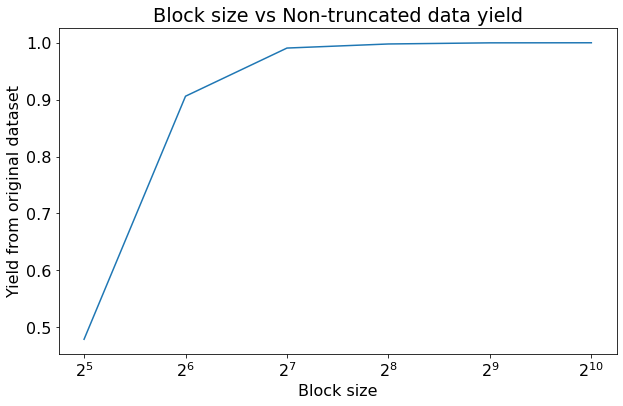

In [9]:
fig, ax = plt.subplots()

ax.set_title("Block size vs Non-truncated data yield")
ax.set_xlabel("Block size")
ax.set_ylabel("Yield from original dataset")
ax.set_xscale('log', basex=2)

ax.plot(list(block_size_to_rows.keys()), list(block_size_to_rows.values()))

plt.show()